In [62]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

In [63]:
using QuantumOptics
using IonSim
import PyPlot
using Random, Distributions
Random.seed!(0)

include("./single_qubit_chamber.jl")
using .SingleQubitChamber: construct_single_qubit_chamber, RX, RY, RZ
const plt = PyPlot;

Globals

In [3]:
N_SAMPLES = Int(1e4)

using .SingleQubitChamber: CALCIUM40 
TIMESCALE = 1e-6 
TRAP_FREQUENCY = 1e6
B_STRENGTH = 4e-4
PI_TIME = 2e-6;

More globals

In [4]:
@time chain = LinearChain(
        ions = [CALCIUM40], 
        comfrequencies = (x = 3e6, y = 3e6, z = TRAP_FREQUENCY), 
        selectedmodes = (;z = [1],)
    )

laser = Laser(Δ=0, ϵ = (x̂ - ẑ)/√2, k = (x̂ + ẑ)/√2, ϕ = 0)
chamber = Chamber(iontrap=chain, B=B_STRENGTH, Bhat=ẑ, δB=0, lasers=[laser]);

WAVELENGTH = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
wavelength!(laser, WAVELENGTH)

INTENSITY = intensity_from_pitime(laser, PI_TIME, CALCIUM40, ("S", "D"), chamber);

Z_PLUS = CALCIUM40["S"]
VIB_MODE =  IonSim.modes(chamber)[1]
ψ0_MOTIONAL = VIB_MODE[0] # GLOBAL: ground state of the first vibrational mode

chain = Nothing
laser = Nothing
chamber = Nothing;

  2.473683 seconds (2.15 M allocations: 137.805 MiB, 2.17% gc time, 99.33% compilation time: 99% of which was recompilation)


Helper function for plotting

In [18]:
function plot_populations(chamber, tout, sol)
    vibrational_mode = IonSim.modes(chamber)[1]

    Z_plus = CALCIUM40["S"]
    Z_minus = CALCIUM40["D"]

    X_plus = (Z_plus + Z_minus)/√2
    X_minus = (Z_plus - Z_minus)/√2

    Y_plus = (Z_plus + im*Z_minus)/√2
    Y_minus = (Z_plus - im*Z_minus)/√2

    prob_X_plus = expect(dm(X_plus) ⊗ one(vibrational_mode), sol)
    prob_X_minus = expect(dm(X_minus) ⊗ one(vibrational_mode), sol)
    prob_Y_plus = expect(dm(Y_plus) ⊗ one(vibrational_mode), sol)
    prob_Y_minus = expect(dm(Y_minus) ⊗ one(vibrational_mode), sol)
    prob_Z_plus = expect(dm(Z_plus) ⊗ one(vibrational_mode), sol)
    prob_Z_minus = expect(dm(Z_minus) ⊗ one(vibrational_mode), sol)

    fig, (x_ax, y_ax, z_ax) = plt.subplots(1, 3, figsize=(15, 5))
    x_ax.plot(tout, prob_X_plus, label="|X+⟩", linewidth=4)
    x_ax.plot(tout, prob_X_minus, "--", label="|X-⟩", linewidth=4)
    x_ax.set_xlim(tout[1], tout[end])
    x_ax.set_ylim(0, 1)
    x_ax.legend(loc=1)
    x_ax.set_xlabel("Time (μs)")

    y_ax.plot(tout, prob_Y_plus, label="|Y+⟩", linewidth=4)
    y_ax.plot(tout, prob_Y_minus, "--", label="|Y-⟩", linewidth=4)
    y_ax.set_xlim(tout[1], tout[end])
    y_ax.set_ylim(0, 1)
    y_ax.legend(loc=1)
    y_ax.set_xlabel("Time (μs)")

    z_ax.plot(tout, prob_Z_plus, label="|Z+⟩", linewidth=4)
    z_ax.plot(tout, prob_Z_minus, "--", label="|Z-⟩", linewidth=4)
    z_ax.set_xlim(tout[1], tout[end])
    z_ax.set_ylim(0, 1)
    z_ax.legend(loc=1)
    z_ax.set_xlabel("Time (μs)")

    return fig
end

plot_populations (generic function with 1 method)

Per "Experimental Bayesian Calibration..." (https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020350), we have the following experimental parameter uncertainties:

Rabi frequency: $\sigma_\Omega = 0.2 \Omega_{\text{opt}}$ 

Center-line frequency: $\sigma_{\omega_{cl}} = 2 \times 2\pi \text{kHz} \Longrightarrow \sigma_{f_{cl}} = 2 kHz$

Sideband detuning: $\sigma_\delta = 2 \times 2\pi \text{kHz} $

Phase: $\sigma_{\Delta \phi} = 0.16\pi$

## 1. Compute uncertainty in intensity

We use a semi-analytical approach to estimate the uncertainty in intensity, $\sigma_I$:

We know $I \propto \Omega^2 \Longrightarrow I = \kappa \Omega^2$. This gives the result: $\sigma_I^2 = \kappa^2 \bigg( 2\sigma_{\Omega}^4 + 4\bar{\Omega}^2 \sigma_{\Omega}^2 \bigg)$. (See $\texttt{Intensity Uncertainty.pdf}$ for the derivation.) The exact value of $\kappa$ is the object of method 2.a., but what we can do here is just estimate $\kappa$ through the following: $\kappa \approx I_{\text{opt}}/\Omega_{\text{opt}}^2$. 

(See $\texttt{intensity\_estimation\_methods.ipynb}$ for the fully-analytic and fully-empirical estimation methods.)

In [6]:
function find_rabi_freq(tout, sol, timescale)
    prob_Z_plus = expect(dm(Z_PLUS) ⊗ one(VIB_MODE), sol);
    prob_Z_plus_1up = broadcast(abs, prob_Z_plus[2:end]);
    max_prob_idx = findall(broadcast(abs, prob_Z_plus_1up.-maximum(prob_Z_plus_1up)) .< 1e-8)[1];
    period = tout[max_prob_idx+1]-tout[1];
    period *= timescale
    freq = 1/period
    return freq
end

find_rabi_freq (generic function with 1 method)

(See $\texttt{rabi\_freq\_func\_test.ipynb}$ for a test of the $\texttt{find\_rabi\_freq}$ function.)

/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


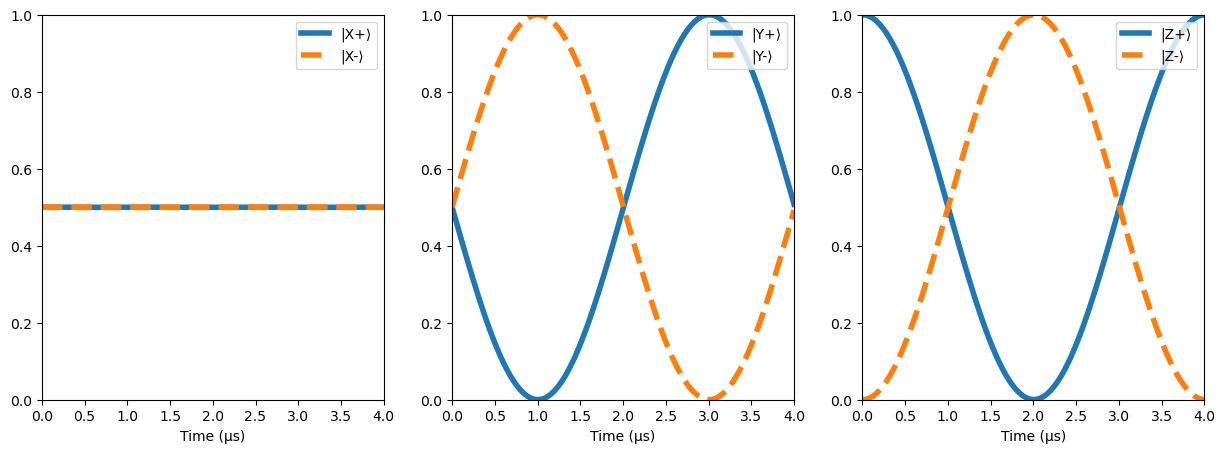

In [19]:
chamber = construct_single_qubit_chamber(
    TRAP_FREQUENCY,
    INTENSITY,
    WAVELENGTH,
    PI_TIME,
    B_STRENGTH
)

# Initial state
ψ0_electronic = CALCIUM40["S"]
ψ0 = Z_PLUS ⊗ ψ0_MOTIONAL# GLOBAL: initial state for all the simulations

# RX(2π)
tout, ψt = RX(2π, chamber, ψ0, PI_TIME, TIMESCALE);

plot_populations(chamber, tout, ψt)

$\sigma_I^2 = \kappa^2 \bigg( 2\sigma_{\Omega}^4 + 4\bar{\Omega}^2 \sigma_{\Omega}^2 \bigg)$.

In [46]:
Ω_opt = find_rabi_freq(tout, ψt, TIMESCALE)
κ = INTENSITY/(Ω_opt^2)

σΩ = 0.2Ω_opt
σI = κ*sqrt(2*(σΩ^4) + 4*(σΩ^2)*Ω_opt^2 )
σI/INTENSITY

0.40398019753448317

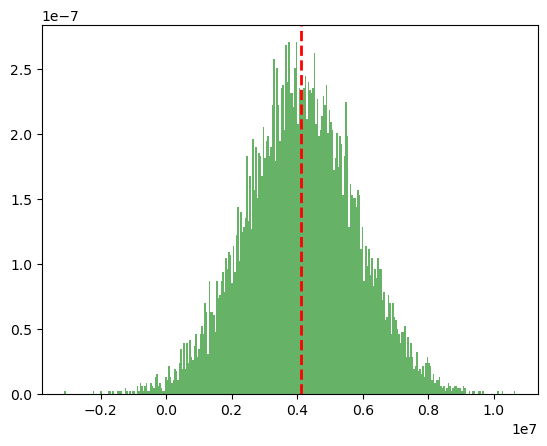

In [47]:
N_I = Normal(INTENSITY, σI)
I_dist = rand(N_I, N_SAMPLES)

fig = plt.figure()
plt.hist(I_dist, bins=300, density=true, alpha=0.6, color="g")
plt.axvline(x=INTENSITY, color="r", linestyle="--", linewidth=2)
plt.display(fig)

# 2. Vary intensity

In [48]:
# Initial state
ψ0_electronic = CALCIUM40["S"]
ψ0 = Z_PLUS ⊗ ψ0_MOTIONAL; # GLOBAL: initial state for all the simulations

In [49]:
fidelities_intensity = zeros(length(I_dist))

for i in 1:N_SAMPLES
    if i%Int(1e3)==0
        print("\n", i)
        flush(stdout)
    end

    I = I_dist[i]
    if I < 0
        fidelities_intensity[i] = NaN
    else
        intensity!(chamber.lasers[1], I)
        tout, ψt = RX(2π, chamber, ψ0, PI_TIME, TIMESCALE)
        fidelities_intensity[i] = real(fidelity(dm(ψt[end]), dm(ψ0)))
    end
end

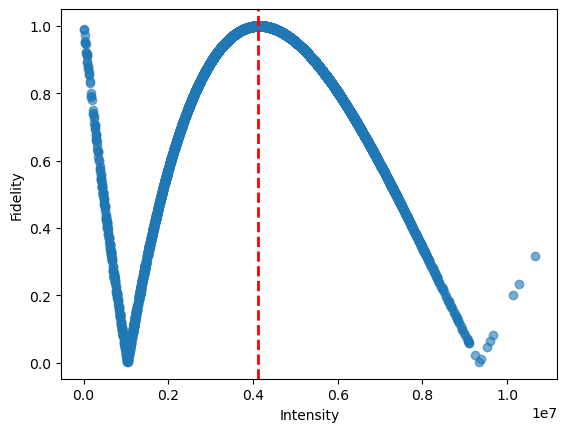

In [51]:
fig = plt.figure()
plt.plot(I_dist, fidelities_intensity, "o", alpha=0.6)
plt.axvline(x=INTENSITY, color="r", linestyle="--", linewidth=2)
plt.xlabel("Intensity")
plt.ylabel("Fidelity")
plt.display(fig)

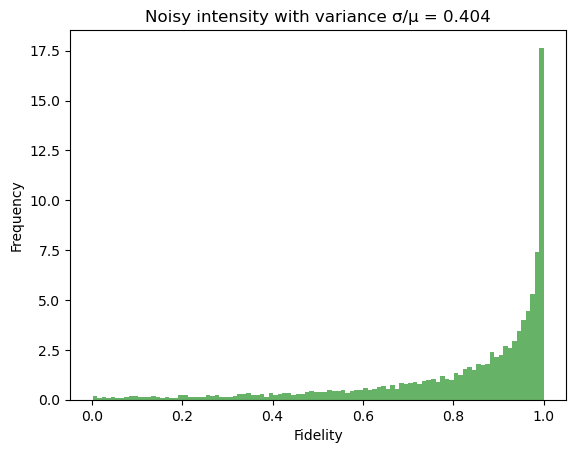

In [61]:
fig = plt.figure()
plt.hist(fidelities_intensity, bins=100, density=true, alpha=0.6, color="g")
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.title("Noisy intensity with variance σ/μ = $(round(σI/INTENSITY; digits=3))")
plt.display(fig)